In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sldata import SessionData

In [23]:
base_path = "d:/data/"
mouse_id = "7012"
session_id = "m10"
experiment = "clickbait-motivate"
cluster = 19

In [6]:
data = SessionData(
    base_path=base_path,
    mouse_id=mouse_id,
    session_id=session_id,
    experiment=experiment,
    min_spikes=50,
    verbose=True)

Successfully loaded spike_times from d:\data\clickbait-motivate\kilosorted\7012\m10\spike_times.npy
Successfully loaded spike_templates from d:\data\clickbait-motivate\kilosorted\7012\m10\spike_templates.npy
Successfully loaded templates from d:\data\clickbait-motivate\kilosorted\7012\m10\templates.npy
Successfully loaded sniff from d:\data\clickbait-motivate\preprocessed\7012\m10\sniff.npy
Loaded data: ['spike_times', 'spike_templates', 'templates', 'sniff']
Successfully loaded events from d:\data\clickbait-motivate\events\7012\m10\events.csv
Video properties: 888x1968, 30.0 FPS, 81815 frames
Loaded cluster labels: 21 good, 23 mua, 14 noise
Excluded 14 noise clusters
Found 22863 peaks in sniff signal
Peak times range: 2.7 - 91559.2 ms
Loaded 43 clusters for 7012_m10
Loaded sniff data: 2746860 samples
Found 22863 sniff events


In [24]:
data.clusters[cluster]

{'cluster_id': 29,
 'label': 'good',
 'best_channel': np.int64(12),
 'spike_times': array([2.99766667e+02, 3.07933333e+02, 3.88233333e+02, ...,
        2.74556137e+06, 2.74557727e+06, 2.74562327e+06], shape=(2904,)),
 'waveform_template': array([-0.3688165 , -0.37066057, -0.35259974, -0.3234678 , -0.30130997,
        -0.31879613, -0.3383137 , -0.3349903 , -0.304613  , -0.31347868,
        -0.34181064, -0.27979487,  0.02406988,  0.47445625,  0.6799    ,
         0.34469128,  0.1223195 ,  1.5352821 ,  5.2667394 ,  9.581572  ,
        11.146077  ,  8.044255  ,  2.2392688 , -2.4798532 , -4.507581  ,
        -4.1933928 , -3.34163   , -3.0451443 , -3.1506035 , -3.1396463 ,
        -2.8204958 , -2.3675332 , -1.9595174 , -1.6309292 , -1.3264658 ,
        -1.0174693 , -0.7060964 , -0.4487006 , -0.23178606, -0.06453174,
         0.08015639,  0.19366097,  0.2819422 ,  0.33268687,  0.3471884 ,
         0.3335721 ,  0.30200422,  0.27562305,  0.260235  ,  0.24475165,
         0.22690797,  0.2104142 

In [85]:
cluster_id = data.clusters[cluster]['cluster_id']
best_channel = data.clusters[cluster_id]['best_channel']
mua = np.load(f"{base_path}{experiment}/preprocessed/{mouse_id}/{session_id}/mua.npy")
theta = mua[best_channel,:]

In [86]:
# Get LFP
sos = signal.butter(3, 8, 'low', fs=30_000, output='sos')
theta = signal.sosfiltfilt(sos, theta)
# Decimate by factor of 30 (30kHz -> 1kHz) and convert to seconds
theta = signal.decimate(theta, 30)
theta = theta - np.mean(theta)
# Normalize between -1 and 1
theta = theta / np.max(np.abs(theta))

In [ ]:
import numpy as np
from scipy.signal import find_peaks

# Find peaks in the theta array
peaks, _ = find_peaks(theta, distance=50)

# Find troughs in the theta array by finding peaks of the negative theta
troughs, _ = find_peaks(-theta, distance=50)

def ensure_alternating_peaks_troughs(peaks, troughs):
    """Ensure peaks and troughs alternate properly."""
    paired_peaks = []
    paired_troughs = []
    
    peak_idx = 0
    trough_idx = 0
    
    # Start with first peak
    while peak_idx < len(peaks) and trough_idx < len(troughs):
        current_peak = peaks[peak_idx]
        
        # Find next trough after this peak
        while trough_idx < len(troughs) and troughs[trough_idx] <= current_peak:
            trough_idx += 1
        
        if trough_idx >= len(troughs):
            break
            
        current_trough = troughs[trough_idx]
        
        # Find next peak after this trough
        next_peak_idx = peak_idx + 1
        while next_peak_idx < len(peaks) and peaks[next_peak_idx] <= current_trough:
            next_peak_idx += 1
        
        # Valid cycle: peak -> trough -> next_peak
        paired_peaks.append(current_peak)
        paired_troughs.append(current_trough)
        
        peak_idx = next_peak_idx
        trough_idx += 1
    
    return np.array(paired_peaks), np.array(paired_troughs)

peaks, troughs = ensure_alternating_peaks_troughs(peaks, troughs)

# Trim peaks and troughs to ensure that we start on a peak
if troughs[0] < peaks[0]:
    troughs = troughs[1:]

# Get spikes 
spikes = data.clusters[cluster]['spike_times']

In [100]:
print(len(troughs))
print(len(peaks))

18005
18005


In [101]:
def assign_phase_by_cycles(signal, peaks, troughs):
    """
    Assign phase by identifying complete cycles (peak-trough-peak).
    """
    phase = np.full_like(signal, np.nan, dtype=float)
    
    # if peaks[0] > troughs[0]:
    #     troughs = troughs[1:]

    # Process each peak-to-peak cycle
    for i in range(len(peaks) - 1):
        peak = peaks[i]
        trough = troughs[i]

        # Ascending phase: peak to trough (0 to π)
        ascending_samples = trough - peak
        phase[peak:trough] = np.linspace(0, np.pi, ascending_samples)
        
        # Descending phase: trough to next peak (π to 2π)
        descending_samples = peaks[i+1] - trough
        phase[trough:peaks[i+1]] = np.linspace(np.pi, 2*np.pi, descending_samples)
    
    return phase

In [102]:
phase = assign_phase_by_cycles(theta, peaks, troughs)

In [103]:
print(phase)
print(f"{np.min(theta)}, {np.max(theta)}, {np.mean(theta)}")

[nan nan nan ... nan nan nan]
-1.0, 0.9384800158176371, 3.0960237856190293e-16


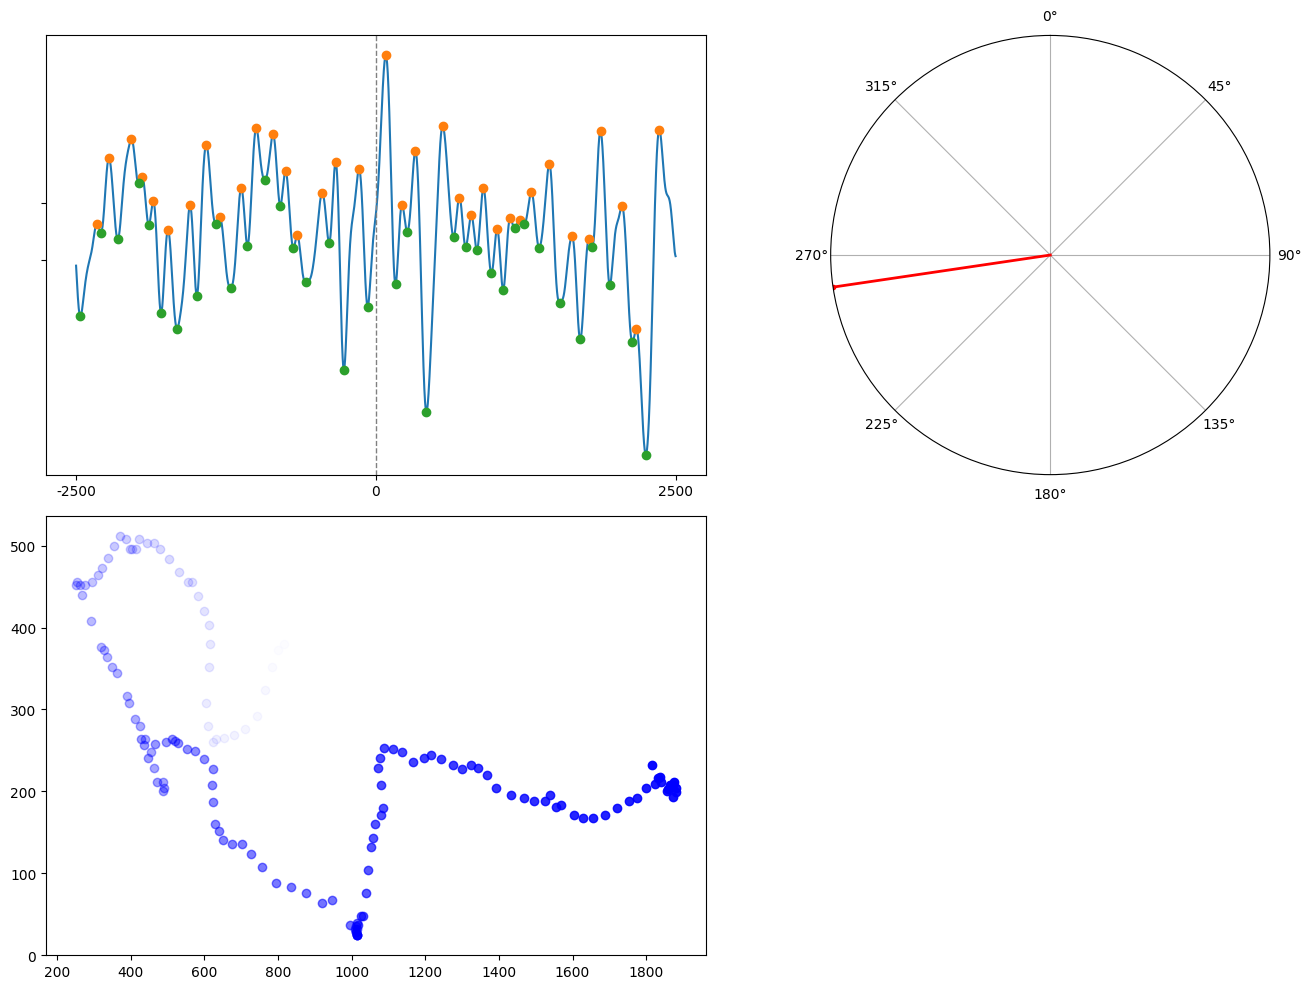

In [ ]:
start = 185000
window = 5000

#for ii in range(1000):
""" Select spikes, peaks, troughs in window """
end = start + window
spike_mask = (spikes >= start) & (spikes <= end)
plot_spikes = spikes[spike_mask] 
plot_spikes = np.array([int(x) for x in plot_spikes], dtype=np.int32)
peak_mask = (peaks >= start) & (peaks <= end)
plot_peaks = peaks[peak_mask]
trough_mask = (troughs >= start) & (troughs <= end)
plot_troughs = troughs[trough_mask]

nose_x = data.events[(data.events['timestamp_ms'] > start) & (data.events['timestamp_ms'] <= end - window//2)]['nose_x'].tolist()
nose_y = data.events[(data.events['timestamp_ms'] > start) & (data.events['timestamp_ms'] <= end - window//2)]['nose_y'].tolist()


# Initialize figure
fig = plt.figure(figsize=(14, 10))

""" Time Series Plot"""
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(theta[start:end])
#ax1.plot(phase[start:end]/100, color='red')
ax1.scatter(plot_spikes-start, theta[plot_spikes])
ax1.scatter(plot_peaks-start, theta[plot_peaks], zorder=5)
ax1.scatter(plot_troughs-start, theta[plot_troughs], zorder=5)
ax1.axvline(window//2, color='grey', linestyle='--', linewidth=1)
ax1.set_yticks([-.1, 0.1]) 
ax1.set_yticklabels([])
ax1.set_xticks([0,window//2, window]) 
ax1.set_xticklabels([-window//2, 0, window//2]) 

""" Polar Phase Plot"""
ax2 = fig.add_subplot(2, 2, 2, projection='polar')
# Define the angle (in radians)
angle = phase[start:end][window//2]  # 45 degrees as example
# Plot a line from center to edge at this angle
ax2.plot([angle, angle], [0, 1], 'r-', linewidth=2) # The line goes from radius 0 to radius 1
# Optional customizations
ax2.plot(angle, 1, 'ro', markersize=3)
ax2.set_ylim(0, 1)  # Set radial limits
ax2.set_theta_zero_location('N')  # Set 0° to top (North)
ax2.set_theta_direction(-1)  # Clockwise
ax2.set_yticks([]) 

""" Trajectory plot"""
ax3 = fig.add_subplot(2, 2, 3)
for ii, point in enumerate(nose_x):
    ax3.scatter(nose_y[ii], nose_x[ii], color='blue', alpha=round(ii/len(nose_x), 2))

# Add spikes to plots
for ii, spike in enumerate(plot_spikes):
    sigmoid = 1 / (1 + np.exp(-(ii - len(plot_spikes)/2)))    
    spike_phase = phase[spike]
    ax2.scatter(spike_phase, .5, color='g', alpha=(window//2-(spike-start) / (window//2)))
    
start += 1

plt.tight_layout()
#plt.savefig(f"A:/phase-plot/phase_test_{ii}.png")
#plt.close()
plt.show()

In [135]:
ii

0

In [139]:
nose_y

5292     831.638489
5293     816.555481
5294     799.623962
5295     783.755188
5296     764.525391
           ...     
5437    1815.724121
5438    1832.159912
5439    1864.098145
5440    1872.487061
5441    1876.541870
Name: nose_y, Length: 150, dtype: float64

In [20]:
# Pxx_spec: power spectral density or power spectrum (depending on scaling)
f, Pxx_spec = signal.welch(theta, 1000, 'flattop', 1024, scaling='spectrum')

In [21]:
max(Pxx_spec)

np.float64(0.059215136483549126)